In [47]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

from tqdm.notebook import tqdm

from joblib import delayed, Parallel

import itertools

from sklearn.decomposition import PCA

In [48]:
df = pd.read_csv('./Video_games_esrb_rating.csv')
# tag_columns = ['alcohol_reference', 'blood', 'suggestive_themes', 'violence']
# X = df[tag_columns]
X = df.drop(columns=['esrb_rating', 'title'])
y = df['esrb_rating']

# PCA

In [49]:
scaler = StandardScaler()
scaler.fit(X)
X_pca = scaler.transform(X)     

In [50]:
pca = PCA(n_components=2)
pca.fit(X_pca)
X_pca = pca.transform(X_pca)
X_pca_df = pd.DataFrame(X_pca, columns=['PC0', 'PC1'])

<Axes: xlabel='PC0', ylabel='PC1'>

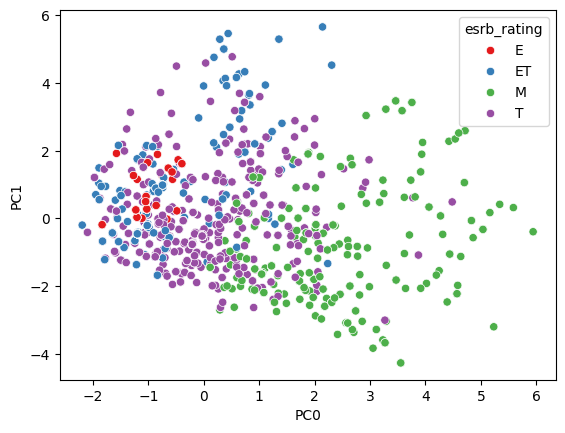

In [51]:
sns.set_palette('seismic')
sns.scatterplot(data=X_pca_df, x='PC0', y='PC1', hue=y, palette='Set1')

# Decision Tree com validação cruzada em dois níveis

In [52]:
def do_dt():
    k1 = 10 #controla o número de vias da validação cruzada para estimar o desempenho do modelo
    k2 = 5 #controla o número de vida da validação cruzada para otimização de hiperparametros

    #usar o protocolo de validação cruzada estratificada
    skf = StratifiedKFold(n_splits=k1, shuffle=True, random_state=1)

    dt_conf_matrix = None

    acuracias = []

    #a função split retorna os índices das instâncias que devem ser usadas para o treinamento e o teste.
    for idx_treino, idx_teste in skf.split(X, y):
        
        #extrair as instâncias de treinamento de acordo com os índices fornecidos pelo skf.split
        X_treino = X.iloc[idx_treino]
        y_treino = y.iloc[idx_treino]
        
        #extrair as instâncias de teste de acordo com os índices fornecidos pelo skf.split
        X_teste = X.iloc[idx_teste]
        y_teste = y.iloc[idx_teste]
        
        #colocar todas as variáveis na mesma escala, usando o conjunto de treinamento para calcular os parâmetros da escala
        ss = StandardScaler()
        ss.fit(X_treino)
        X_treino = ss.transform(X_treino)
        X_teste = ss.transform(X_teste)
        
        #combinações de parametros otimizar. Aqui estamos apenas otimizando o número de vizinhos mais próximos para o knn (k).
        #Entretanto, podemos colocar todos os valores de todos os parametros. O sklearn se encarrega de gerar todas as combinações.
        params = {
            'max_depth': [None, 2, 3, 4, 5],
            'min_samples_leaf': [1, 3, 5, 10, 15],
            'min_samples_split': [2, 4, 8, 16, 32]
        }
        #instanciar um KNN com parametros padrão
        dt = DecisionTreeClassifier()

        #instanciar um GridSearchCV com k2 vias.
        dt_classifier = GridSearchCV(dt, params, cv=StratifiedKFold(n_splits=k2), scoring='f1_weighted')
        
        #realizar a otimização dos hiperparâmetros e treinar o modelo final com a melhor combinação de hiperparametros com todos os dados de treinamento
        dt_classifier.fit(X_treino, y_treino)
        
        pred = dt_classifier.predict(X_teste)
        print(classification_report(y_teste, pred, zero_division=0))
        
        cm = confusion_matrix(y_teste, pred)
        if dt_conf_matrix is None:
            dt_conf_matrix = cm
        else:
            dt_conf_matrix += cm

        f1 = f1_score(y_teste, pred, average='weighted')
        acuracias.append(f1)
    
    return acuracias, dt_conf_matrix, dt_classifier.best_params_
    
# print("Soma das matrizes de confusão:")
# print(conf_matrix)

In [53]:
dt_acuracia, dt_conf_matrix, best_params = do_dt()

              precision    recall  f1-score   support

           E       1.00      0.93      0.96        42
          ET       0.79      0.85      0.82        40
           M       0.81      0.90      0.85        39
           T       0.83      0.78      0.81        69

    accuracy                           0.85       190
   macro avg       0.86      0.86      0.86       190
weighted avg       0.86      0.85      0.85       190

              precision    recall  f1-score   support

           E       1.00      0.95      0.98        42
          ET       0.79      0.95      0.86        40
           M       0.92      0.85      0.88        39
           T       0.89      0.86      0.87        69

    accuracy                           0.89       190
   macro avg       0.90      0.90      0.90       190
weighted avg       0.90      0.89      0.90       190

              precision    recall  f1-score   support

           E       0.88      1.00      0.93        42
          ET       0.

# Treinando o modelo com os melhores parâmetros encontrados e plotando a árvore

Melhores parâmetros: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 4}


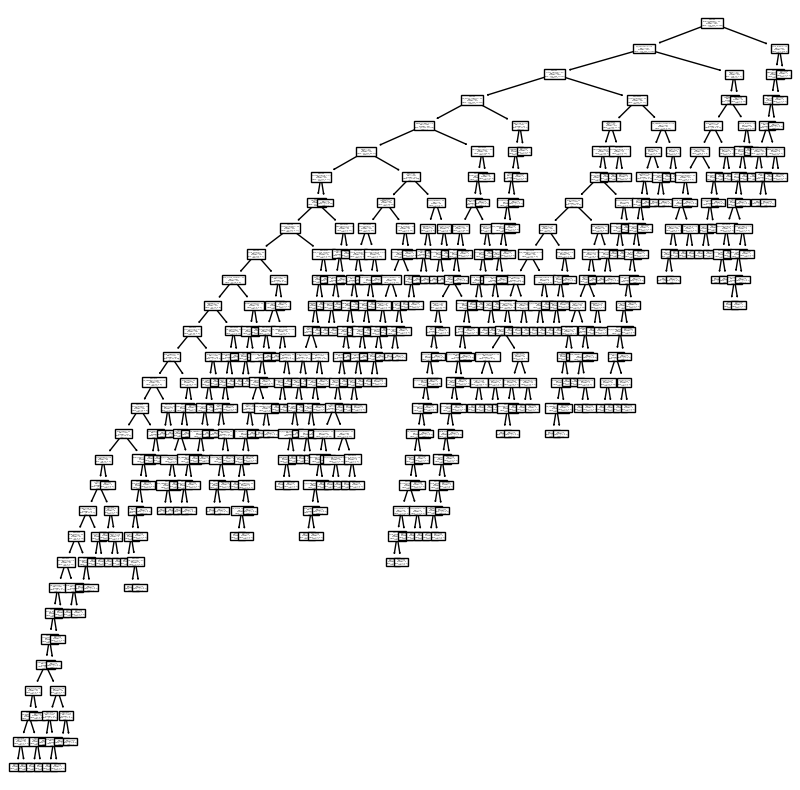

In [54]:
print("Melhores parâmetros:", best_params) # exibe os melhores parâmetros

dt = DecisionTreeClassifier(**best_params) # instanciando o modelo com os melhores parâmetros

dt.fit(X, y) # treinando o modelo com todos os dados

# plotando a árvore de decisão
plt.figure(figsize=(10,10))
plot_tree(dt, class_names=dt.classes_, feature_names=X.columns, node_ids=True)
plt.show()

## Exibindo a estrutura das regras da árvore de decisão

In [55]:
from sklearn.tree import _tree

In [56]:
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 3)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if "
        
        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
        rule += " then "
        if class_names is None:
            rule += "response: "+str(np.round(path[-1][0][0][0],3))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),2)}%)"
        rule += f" | based on {path[-1][1]:,} samples"
        rules += [rule]
        
    return rules

get_rules(dt, X.columns.tolist(), dt.classes_)


['if (strong_janguage <= 0.5) and (no_descriptors > 0.5) and (blood <= 0.5) and (language <= 0.5) and (mild_blood <= 0.5) and (alcohol_reference <= 0.5) and (suggestive_themes <= 0.5) and (intense_violence <= 0.5) and (mild_lyrics <= 0.5) and (crude_humor <= 0.5) then class: E (proba: 100.0%) | based on 263 samples',
 'if (strong_janguage > 0.5) and (mature_humor <= 0.5) and (animated_blood <= 0.5) and (crude_humor <= 0.5) and (mild_blood <= 0.5) and (drug_reference <= 0.5) then class: M (proba: 100.0%) | based on 193 samples',
 'if (strong_janguage <= 0.5) and (no_descriptors <= 0.5) and (fantasy_violence > 0.5) and (suggestive_themes <= 0.5) and (blood <= 0.5) and (strong_sexual_content <= 0.5) and (sexual_themes <= 0.5) and (mild_blood <= 0.5) and (language <= 0.5) and (mild_suggestive_themes <= 0.5) and (mild_violence <= 0.5) and (sexual_content <= 0.5) and (mild_lyrics <= 0.5) and (use_of_drugs_and_alcohol <= 0.5) and (console <= 0.5) then class: ET (proba: 94.17%) | based on 103 

# Random Forest com validação cruzada em dois níveis

In [59]:
from sklearn.ensemble import RandomForestClassifier

In [60]:
def do_rf():
    k1 = 10 #controla o número de vias da validação cruzada para estimar o desempenho do modelo
    k2 = 5 #controla o número de vida da validação cruzada para otimização de hiperparametros

    # usar o protocolo de validação cruzada estratificada
    skf = StratifiedKFold(n_splits=k1, shuffle=True, random_state=1)

    rf_conf_matrix = None
    acuracias = []

    # a função split retorna os índices das instâncias que devem ser usadas para o treinamento e o teste.
    for idx_treino, idx_teste in skf.split(X, y):

        # extrair as instâncias de treinamento de acordo com os índices fornecidos pelo skf.split
        X_treino = X.iloc[idx_treino]
        y_treino = y.iloc[idx_treino]

        # extrair as instâncias de teste de acordo com os índices fornecidos pelo skf.split
        X_teste = X.iloc[idx_teste]
        y_teste = y.iloc[idx_teste]

        # colocar todas as variáveis na mesma escala, usando o conjunto de treinamento para calcular os parâmetros da escala
        ss = StandardScaler()
        ss.fit(X_treino)
        X_treino = ss.transform(X_treino)
        X_teste = ss.transform(X_teste)

        # combinações de parametros otimizar. Aqui estamos apenas otimizando o número de vizinhos mais próximos para o knn (k).
        # Entretanto, podemos colocar todos os valores de todos os parametros. O sklearn se encarrega de gerar todas as combinações.
        params={
            'criterion' : ['gini', 'entropy'], 
            'random_state' : [1], 
            'n_estimators': [100, 200, 500],
        }

        # instanciar um KNN com parametros padrão
        rf = RandomForestClassifier()

        # instanciar um GridSearchCV com k2 vias.
        rf = GridSearchCV(rf, params, cv=StratifiedKFold(n_splits=k2), scoring='f1_weighted')
        
        # realizar a otimização dos hiperparâmetros e treinar o modelo final com a melhor combinação de hiperparametros com todos os dados de treinamento
        rf.fit(X_treino, y_treino)

        # predizer os dados de teste usando o modelo treinado
        pred = rf.predict(X_teste)

        # calcular a acurácia do modelo na base de teste e imprimir
        print(classification_report(y_teste, pred))

        # calcular a matriz de confusão do modelo na base de teste e imprimir
        cm = confusion_matrix(y_teste, pred)
        if rf_conf_matrix is None:
            rf_conf_matrix = cm
        else:
            rf_conf_matrix += cm

        f1 = f1_score(y_teste, pred, average='weighted')
        acuracias.append(f1)

    return acuracias, rf_conf_matrix
    # imprimir a soma das matrizes de confusão
    # print("Soma das matrizes de confusão:")
    # print(conf_matrix)


# KNN com validação cruzada em dois níveis

In [61]:
from sklearn.neighbors import KNeighborsClassifier

In [63]:
def do_knn():
    k1 = 10 #controla o número de vias da validação cruzada para estimar o desempenho do modelo
    k2 = 5 #controla o número de vida da validação cruzada para otimização de hiperparametros

    # usar o protocolo de validação cruzada estratificada
    skf = StratifiedKFold(n_splits=k1, shuffle=True, random_state=1)

    knn_conf_matrix = None
    acuracias = []

    # a função split retorna os índices das instâncias que devem ser usadas para o treinamento e o teste.
    for idx_treino, idx_teste in skf.split(X, y):

        # extrair as instâncias de treinamento de acordo com os índices fornecidos pelo skf.split
        X_treino = X.iloc[idx_treino]
        y_treino = y.iloc[idx_treino]

        # extrair as instâncias de teste de acordo com os índices fornecidos pelo skf.split
        X_teste = X.iloc[idx_teste]
        y_teste = y.iloc[idx_teste]

        # colocar todas as variáveis na mesma escala, usando o conjunto de treinamento para calcular os parâmetros da escala
        ss = StandardScaler()
        ss.fit(X_treino)
        X_treino = ss.transform(X_treino)
        X_teste = ss.transform(X_teste)

        # combinações de parametros otimizar. Aqui estamos apenas otimizando o número de vizinhos mais próximos para o knn (k).
        # Entretanto, podemos colocar todos os valores de todos os parametros. O sklearn se encarrega de gerar todas as combinações.
        params = {'n_neighbors' : range(1,30,2)}

        # instanciar um KNN com parametros padrão
        knn = KNeighborsClassifier(metric='euclidean')

        # instanciar um GridSearchCV com k2 vias.
        knn = GridSearchCV(knn, params, cv=StratifiedKFold(n_splits=k2), scoring='f1_weighted')
        
        # realizar a otimização dos hiperparâmetros e treinar o modelo final com a melhor combinação de hiperparametros com todos os dados de treinamento
        knn.fit(X_treino, y_treino)

        pred = knn.predict(X_teste)
        # f1 = f1_score(y_teste, pred, average='weighted')
        # print("F1-Score:", f1)
        print(classification_report(y_teste, pred))

        cm = confusion_matrix(y_teste, pred)
        if knn_conf_matrix is None:
            knn_conf_matrix = cm
        else:
            knn_conf_matrix += cm

        f1 = f1_score(y_teste, pred, average='weighted')
        acuracias.append(f1)

    return acuracias, knn_conf_matrix

    # print("Soma das matrizes de confusão:")
    # print(conf_matrix)


# SVM com validação cruzada em dois níveis

In [64]:
from sklearn.svm import SVC

In [65]:
def do_svm():
    k1 = 10 #controla o número de vias da validação cruzada para estimar o desempenho do modelo
    k2 = 5 #controla o número de vida da validação cruzada para otimização de hiperparametros

    #usar o protocolo de validação cruzada estratificada
    skf = StratifiedKFold(n_splits=k1, shuffle=True, random_state=1)

    svm_conf_matrix = None
    acuracias = []

    #a função split retorna os índices das instâncias que devem ser usadas para o treinamento e o teste.
    for idx_treino, idx_teste in skf.split(X, y):
        
        #extrair as instâncias de treinamento de acordo com os índices fornecidos pelo skf.split
        X_treino = X.iloc[idx_treino]
        y_treino = y.iloc[idx_treino]
        
        #extrair as instâncias de teste de acordo com os índices fornecidos pelo skf.split
        X_teste = X.iloc[idx_teste]
        y_teste = y.iloc[idx_teste]
        
        #colocar todas as variáveis na mesma escala, usando o conjunto de treinamento para calcular os parâmetros da escala
        ss = StandardScaler()
        ss.fit(X_treino)
        X_treino = ss.transform(X_treino)
        X_teste = ss.transform(X_teste)
        
        #combinações de parametros otimizar. Aqui estamos apenas otimizando o número de vizinhos mais próximos para o knn (k).
        #Entretanto, podemos colocar todos os valores de todos os parametros. O sklearn se encarrega de gerar todas as combinações.
        params = {
            'C': [0.1, 1, 10, 100, 1000],
            'gamma': ['scale', 'auto', 2e-2, 2e-3, 2e-4],
        }
        #instanciar um SVM com parametros padrão
        svm = SVC(kernel='rbf')

        #instanciar um GridSearchCV com k2 vias.
        svm = GridSearchCV(svm, params, cv=StratifiedKFold(n_splits=k2), scoring='f1_weighted')

        #realizar a otimização dos hiperparâmetros e treinar o modelo final com a melhor combinação de hiperparametros com todos os dados de treinamento
        svm.fit(X_treino, y_treino)

        pred = svm.predict(X_teste)
        # f1 = f1_score(y_teste, pred, average='weighted')
        # print("F1-Score:", f1)
        print(classification_report(y_teste, pred))

        cm = confusion_matrix(y_teste, pred)
        if svm_conf_matrix is None:
            svm_conf_matrix = cm
        else:
            svm_conf_matrix += cm

        f1 = f1_score(y_teste, pred, average='weighted')
        acuracias.append(f1)

    return acuracias, svm_conf_matrix

    # print("Soma das matrizes de confusão:")
    # print(conf_matrix)
        

# Teste de parâmetro T do Student

In [57]:
dt_acuracia, dt_conf_matrix, _ = do_dt()

              precision    recall  f1-score   support

           E       1.00      0.93      0.96        42
          ET       0.82      0.90      0.86        40
           M       0.78      0.90      0.83        39
           T       0.85      0.77      0.81        69

    accuracy                           0.86       190
   macro avg       0.86      0.87      0.87       190
weighted avg       0.86      0.86      0.86       190

              precision    recall  f1-score   support

           E       1.00      0.95      0.98        42
          ET       0.79      0.95      0.86        40
           M       0.92      0.85      0.88        39
           T       0.89      0.86      0.87        69

    accuracy                           0.89       190
   macro avg       0.90      0.90      0.90       190
weighted avg       0.90      0.89      0.90       190

              precision    recall  f1-score   support

           E       0.88      1.00      0.93        42
          ET       0.

In [58]:
print("Soma das matrizes de confusão - Decision Tree:")
print(dt_conf_matrix)

Soma das matrizes de confusão - Decision Tree:
[[404   8   0   4]
 [ 19 331   2  51]
 [  1   4 337  45]
 [  9  91  54 535]]


In [66]:
rf_acuracia, rf_conf_matrix = do_rf()

              precision    recall  f1-score   support

           E       1.00      0.93      0.96        42
          ET       0.84      0.90      0.87        40
           M       0.84      0.92      0.88        39
           T       0.88      0.83      0.85        69

    accuracy                           0.88       190
   macro avg       0.89      0.89      0.89       190
weighted avg       0.89      0.88      0.88       190

              precision    recall  f1-score   support

           E       1.00      0.95      0.98        42
          ET       0.80      0.90      0.85        40
           M       0.92      0.87      0.89        39
           T       0.87      0.86      0.86        69

    accuracy                           0.89       190
   macro avg       0.90      0.89      0.89       190
weighted avg       0.89      0.89      0.89       190

              precision    recall  f1-score   support

           E       0.89      1.00      0.94        42
          ET       0.

In [67]:
print("Soma das matrizes de confusão - Random Forest:")
print(rf_conf_matrix)

Soma das matrizes de confusão - Random Forest:
[[404  10   0   2]
 [ 22 328   0  53]
 [  0   0 341  46]
 [  8  81  41 559]]


In [68]:
knn_acuracia, knn_conf_matrix = do_knn()

              precision    recall  f1-score   support

           E       0.93      0.95      0.94        42
          ET       0.76      0.80      0.78        40
           M       0.71      0.92      0.80        39
           T       0.78      0.61      0.68        69

    accuracy                           0.79       190
   macro avg       0.79      0.82      0.80       190
weighted avg       0.79      0.79      0.78       190

              precision    recall  f1-score   support

           E       0.98      0.98      0.98        42
          ET       0.85      0.88      0.86        40
           M       0.73      0.85      0.79        39
           T       0.82      0.74      0.78        69

    accuracy                           0.84       190
   macro avg       0.85      0.86      0.85       190
weighted avg       0.84      0.84      0.84       190

              precision    recall  f1-score   support

           E       0.84      1.00      0.91        42
          ET       0.

In [69]:
print("Soma das matrizes de confusão - KNN:")
print(knn_conf_matrix)

Soma das matrizes de confusão - KNN:
[[408   2   0   6]
 [ 27 303   0  73]
 [  2   1 338  46]
 [ 20  95  88 486]]


In [70]:
svm_acuracia, svm_conf_matrix = do_svm()

              precision    recall  f1-score   support

           E       1.00      0.95      0.98        42
          ET       0.83      0.85      0.84        40
           M       0.81      0.90      0.85        39
           T       0.83      0.80      0.81        69

    accuracy                           0.86       190
   macro avg       0.87      0.87      0.87       190
weighted avg       0.87      0.86      0.86       190

              precision    recall  f1-score   support

           E       1.00      0.95      0.98        42
          ET       0.82      0.90      0.86        40
           M       0.92      0.85      0.88        39
           T       0.86      0.87      0.86        69

    accuracy                           0.89       190
   macro avg       0.90      0.89      0.89       190
weighted avg       0.89      0.89      0.89       190

              precision    recall  f1-score   support

           E       0.93      1.00      0.97        42
          ET       0.

In [71]:
print("Soma das matrizes de confusão - SVM:")
print(svm_conf_matrix)

Soma das matrizes de confusão - SVM:
[[407   8   0   1]
 [ 12 325   0  66]
 [  0   0 346  41]
 [  5  85  38 561]]


In [72]:
def calcular_estatisticas(resultados):
    return np.mean(resultados), np.std(resultados), np.min(resultados), np.max(resultados)

def imprimir_estatisticas(resultados):
    media, desvio, mini, maxi = calcular_estatisticas(resultados)
    print("Resultados: %.2f +- %.2f, min: %.2f, max: %.2f" % (media, desvio, mini, maxi))

In [73]:
from scipy.stats import ttest_ind_from_stats

In [74]:
def rejeitar_hip_nula(media_amostral1, desvio_padrao_amostral1, n1, media_amostral2, desvio_padrao_amostral2, n2, alpha=0.05):
    _, pvalor = ttest_ind_from_stats(media_amostral1, desvio_padrao_amostral1, n1, media_amostral2, desvio_padrao_amostral2, n2)
    return pvalor <= alpha

In [75]:
imprimir_estatisticas(dt_acuracia)
imprimir_estatisticas(rf_acuracia)
imprimir_estatisticas(knn_acuracia)
imprimir_estatisticas(svm_acuracia)

Resultados: 0.85 +- 0.02, min: 0.82, max: 0.90
Resultados: 0.86 +- 0.03, min: 0.82, max: 0.90
Resultados: 0.81 +- 0.03, min: 0.76, max: 0.84
Resultados: 0.86 +- 0.03, min: 0.83, max: 0.91


In [ ]:
media_dt, std_dt, _, _ = calcular_estatisticas(dt_acuracia)
media_rf, std_rf, _, _ = calcular_estatisticas(rf_acuracia)
media_knn, std_knn, _, _ = calcular_estatisticas(knn_acuracia)
media_svm, std_svm, _, _ = calcular_estatisticas(svm_acuracia)
